In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk

from scipy import optimize
from scipy.signal import find_peaks
from astropy.stats import LombScargle

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

from lmfit import Model

import scipy.special
import math

from astropy.io import fits

import random

from astropy.time import Time

import os

from scipy.ndimage import gaussian_filter
from astropy.stats import sigma_clip

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

plt.rc('font', family='serif', size=11)
plt.tight_layout()

<Figure size 900x600 with 0 Axes>

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


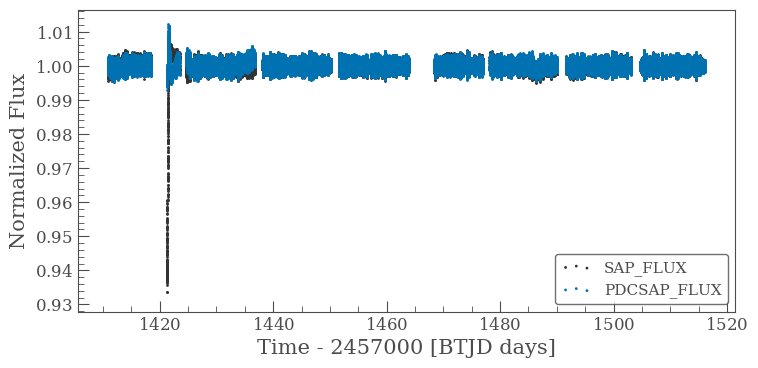

In [3]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = -2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)
        
        x = times
        y = mags

In [4]:
jds = []
for i in np.arange(2018, 2023, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2018-01-01T12:00:00.000']
[2458120.]
['2019-01-01T12:00:00.000']
[2458485.]
['2020-01-01T12:00:00.000']
[2458850.]
['2021-01-01T12:00:00.000']
[2459216.]
['2022-01-01T12:00:00.000']
[2459581.]


In [5]:
#Expected units:
#t ... Time in days
#a1sini ... in seconds
#Porb ... in days
#star_planet_ratio ... how many times heavier is the star?

def tau(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = -a2sini / star_planet_ratio * 499 / 86400
    term2 = (1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (sinf * np.cos(varpi) + cosf * np.sin(varpi))/(1. + e*cosf)
    
    sol = term1*term2*term3
    
    return sol

def vrad(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio *1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) - sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1*term2*term3
    
    return sol

def vrad2(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio  * 1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) + sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1/term2*term3
    
    return sol

In [6]:
times

array([2458410.90352425, 2458410.90491317, 2458410.90630209, ...,
       2458516.08417223, 2458516.08556108, 2458516.08694993])

In [7]:
jds = []
for i in np.arange(2018, 2023, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2018-01-01T12:00:00.000']
[2458120.]
['2019-01-01T12:00:00.000']
[2458485.]
['2020-01-01T12:00:00.000']
[2458850.]
['2021-01-01T12:00:00.000']
[2459216.]
['2022-01-01T12:00:00.000']
[2459581.]


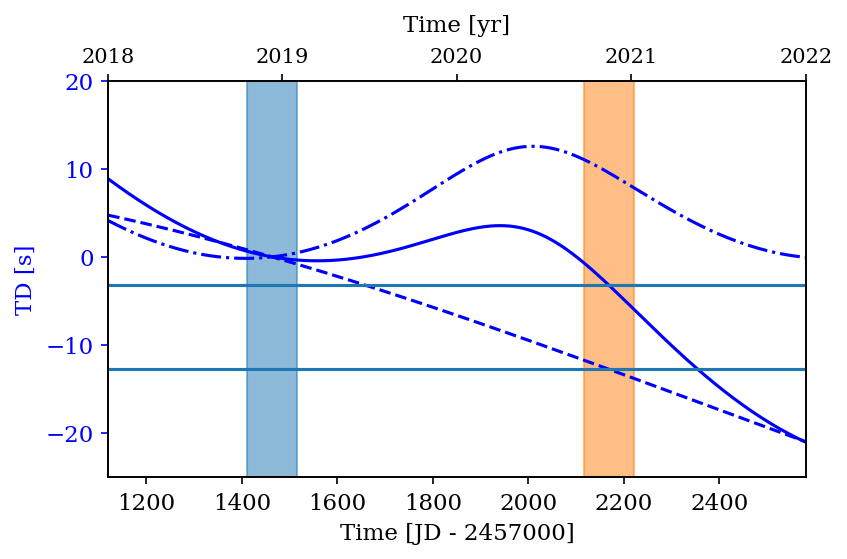

In [8]:
t_18_22 = np.linspace(jds[0], jds[-1], 300)


#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.93 * 1048
a2sini_c = 2.6947 * np.sin(np.deg2rad(88.81))
e_c = 0.2425
varpi_c = np.deg2rad(-95.2)
Porb_c = 1220
tp_c = 2454116.5


TESS_mm_tmid = min(times) + (max(times) - min(times))/2

y_tau_b_offset = tau(TESS_mm_tmid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_offset = tau(TESS_mm_tmid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

y_tau_b = tau(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b = vrad2(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c = vrad2(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

time_offset = 2457000

fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))


ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

lns11 = ax1.plot(t_18_22 - time_offset, (y_tau_b + y_tau_c-y_tau_b_offset-y_tau_c_offset) * 86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(t_18_22 - time_offset, (y_tau_b-y_tau_b_offset) * 86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(t_18_22 - time_offset, (y_tau_c-y_tau_c_offset) * 86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")




lns31 = ax1.axvspan(min(times) - time_offset, max(times) - time_offset, alpha=0.5,  label='TESS (mm)', color='C0')
lns32 = ax1.axvspan(min(times)+705 - time_offset, max(times)+705 - time_offset, alpha=0.5,  label='TESS (em)', color='C1')

ax1.set_xlabel('Time [JD - 2457000]')
ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-25,20)


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset
t_2022 = jds[4] - time_offset


ax2.set_xticks([t_2018,t_2019,t_2020,t_2021,t_2022])


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2018', '2019', '2020', '2021', '2022'], fontsize=10)
ax2.set_xlabel('Time [yr]')
ax2.xaxis.set_label_coords(0.5,1.125)

ax1.axhline((tau(TESS_mm_tmid+705, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400)
ax1.axhline((tau(TESS_mm_tmid+705, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)-y_tau_c_offset+tau(TESS_mm_tmid+705, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400)

In [84]:
(tau(TESS_mm_tmid+705, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400

-12.749688187948712

In [85]:
(tau(TESS_mm_tmid+705, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)-y_tau_c_offset+tau(TESS_mm_tmid+705, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400

-3.1959326480889536

In [86]:
(tau(TESS_mm_tmid+705, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400-(tau(TESS_mm_tmid+705, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)-y_tau_c_offset+tau(TESS_mm_tmid+705, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400

-9.553755539859758

# TESS Gaussian HPF

In [9]:
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))

In [10]:
def dft_phase(x, y, freq):
    """ 
    Discrete fourier transform to calculate the ASTC phase
    given x, y, and an array of frequencies
    
    Parameters
    ----------
        x : `array`
            Array in which to calculate 
        x : `array`
    
    Returns:
    ----------
        phase : `list`
            A list of phases for the given frequencies
    """

    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
        
        
    ## my phase wrapping patch
    tmp = []
    for i in phase:
        if i < 0:
            tmp.append(i + 2 * np.pi)
        else:
            tmp.append(i)

    p = np.array(tmp)
    p = (- p + np.pi/2) % (2 * np.pi)

    return p

In [11]:
print('Calculate AS')
#AS
freq, amp = AS(times, mags, 15)

freq=freq[5000:]
amp=amp[5000:]

# PEAKS
max_power = amp.max()

peaks, _ = find_peaks(amp, height=max_power*0.02, distance=200)

# FREQS SORTED BY AMPLITUDE
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(len(f_TESS))


print('Calculate Phases')
# PHASES
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)



# SELECT HOW MANY FREQS FOR COMPARISON

n = 50

f_TESS = f_TESS[:n]
a_TESS = a_TESS[:n]
p_TESS = p_TESS[:n]

Calculate AS


82
Calculate Phases


In [12]:
def highpass(flux, order, sigma):
    highpass_lst = []
    highpass_lst.append(flux)
    
    for i in range(0, order):
        lowpass = gaussian_filter(highpass_lst[i], sigma=sigma)
        highpass = highpass_lst[i] - lowpass
        highpass_lst.append(highpass)

    return highpass_lst

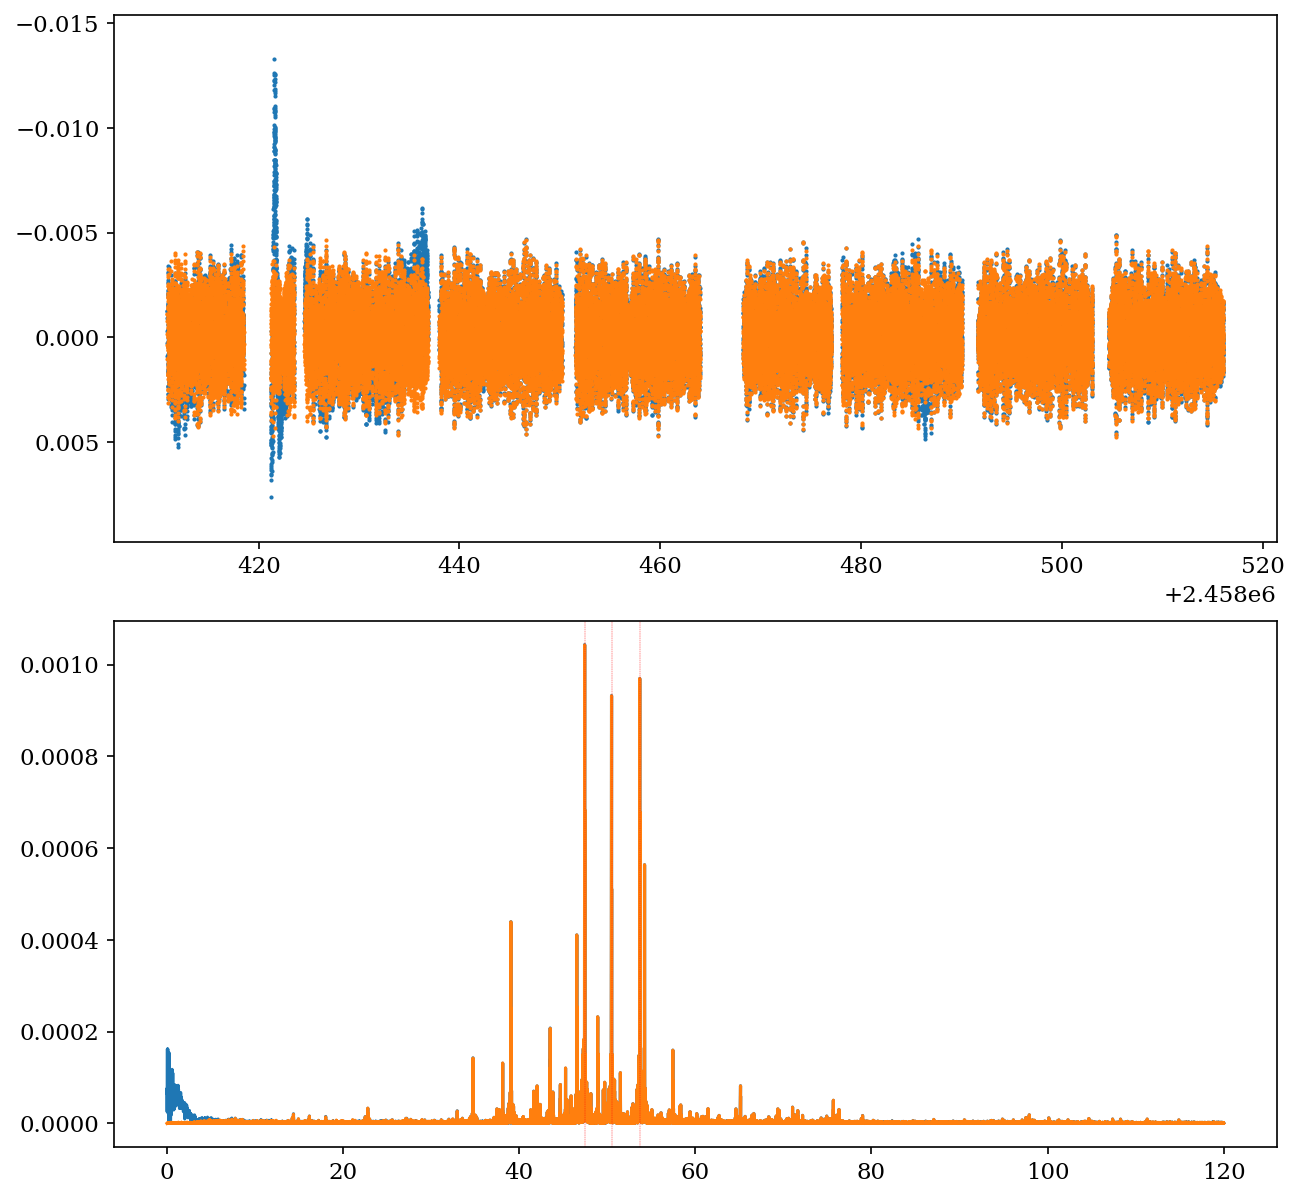

In [13]:
highpass_own = highpass(mags, 5, 50)
hpmax = len(highpass_own)-1

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].scatter(times, highpass_own[0], s=1, label='{0}'.format(i), alpha=1, c='C0')
ax[0].scatter(times, highpass_own[hpmax], s=1, label='{0}'.format(i), alpha=1, c='C1')
ax[0].invert_yaxis()

plt.subplots_adjust(hspace=0.15)


#AS
freq_tmp, amp_tmp = AS(times, highpass_own[0], 15)
ax[1].plot(freq_tmp, amp_tmp)

freq_tmp, amp_tmp = AS(times, highpass_own[hpmax], 15)
ax[1].plot(freq_tmp, amp_tmp)

for i in range(3):
    ax[1].axvline(f_TESS[i], c='r', ls='--', lw=0.2)
    
mags_gaus = highpass_own[hpmax]

In [14]:
#Fourier Function
def fourier_sum(freqs, amps, phase, y_noise, x):
    y = []
    for j in range(0, len(x)):
        temp = []
        temp.append(y_noise[j])
        for i in range(0, len(freqs)):
            #next line: sum(amplitude_i * sine(freq_i * x + phase_i)) for all pulsations i 
            temp.append(amps[i]*np.sin(2.*np.pi*freqs[i]*x[j]+phase[i]))
        y.append(sum(temp))
    return y

def lc_sim(freqs, amps, phs, time_start, time_end, cadence, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time = np.arange(time_start, time_end, cadence)
    noise = np.random.normal(0, precision, len(time))
    
    multisine = np.array(fourier_sum(freqs, amps, phs, noise, time))

    return [freqs, amps, phs, time, multisine]

def lc_model(freqs, amps, phs, time_start, time_end, cadence_model):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = np.arange(time_start, time_end, cadence_model)
    noise_model = [0 for i in time_model]    

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

def lc_model_times(freqs, amps, phs, times, precision):
    freqs = np.array(freqs)
    amps = np.array(amps)
    phs = np.array(phs)
    
    time_model = times
    noise_model = np.random.normal(0, precision, len(time_model))
    #noise_model = [0 for i in time_model]  

    multisine_model = np.array(fourier_sum(freqs, amps, phs, noise_model, time_model))

    return [freqs, amps, phs, time_model, multisine_model]

In [15]:
#Expected units:
#t ... Time in days
#a1sini ... in seconds
#Porb ... in days
#star_planet_ratio ... how many times heavier is the star?

def tau(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = -a2sini / star_planet_ratio * 499 / 86400
    term2 = (1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (sinf * np.cos(varpi) + cosf * np.sin(varpi))/(1. + e*cosf)
    
    sol = term1*term2*term3
    
    return sol

def vrad(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio *1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) - sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1*term2*term3
    
    return sol

def vrad2(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio  * 1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) + sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1/term2*term3
    
    return sol

In [16]:
t_18_22 = np.linspace(jds[0], jds[-1], 300)


#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.93 * 1048
a2sini_c = 2.6947 * np.sin(np.deg2rad(88.81))
e_c = 0.2425
varpi_c = np.deg2rad(-95.2)
Porb_c = 1220
tp_c = 2454116.5

y_tau_b = tau(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_vrad_b = vrad2(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c = tau(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_vrad_c = vrad2(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

# plt.plot(t_18_22, y_vrad_b)
# plt.plot(t_18_22, y_vrad_c)
# plt.plot(t_18_22, y_vrad_b + y_vrad_c)

In [17]:
jds = []
for i in np.arange(2018, 2023, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2018-01-01T12:00:00.000']
[2458120.]
['2019-01-01T12:00:00.000']
[2458485.]
['2020-01-01T12:00:00.000']
[2458850.]
['2021-01-01T12:00:00.000']
[2459216.]
['2022-01-01T12:00:00.000']
[2459581.]


In [18]:
def jd_to_datetime(jd, returniso=False):

    tt = Time(jd, format='jd', scale='utc')

    if returniso:
        return tt.iso
    else:
        return tt.datetime 

In [19]:
#https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i
def fit_leastsq_my(times, mags, freqs, amps, phs):
    
    pfit_all = []
    perr_all = []
    
    for i in range(len(freqs)):

        def model_new(freq):
            def f(x, p1, p2):
                return abs(p1) * np.sin(2. * np.pi * (freq * x + (p2)%1))
            return f
        
        def ff(x, p):
            return model_new(freqs[i])(x, *p)
        
        # These are initial guesses for fits:
        pstart = [amps[i], phs[i]]
    
        def fit_leastsq(p0, datax, datay, function):

            errfunc = lambda p, x, y: function(x,p) - y

            pfit, pcov, infodict, errmsg, success = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=1, epsfcn=0.0001)

            if (len(datay) > len(p0)) and pcov is not None:
                s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
                pcov = pcov * s_sq
            else:
                pcov = np.inf

            error = [] 
            for i in range(len(pfit)):
                try:
                    error.append(np.absolute(pcov[i][i])**0.5)
                except:
                    error.append( 0.00 )
            pfit_leastsq = pfit
            perr_leastsq = np.array(error) 
            return pfit_leastsq, perr_leastsq 

        pfit, perr = fit_leastsq(pstart, times, mags, ff)
        pfit_all.append(pfit)
        perr_all.append(perr)
        
    my_amps = np.array([pfit_all[i][0] for i in range(len(freqs))])
    my_phs = np.array([pfit_all[i][1] for i in range(len(freqs))])
    my_phs_err = np.array([perr_all[i][1] for i in range(len(freqs))])
    
    return(freqs, my_amps, my_phs, my_phs_err)

In [133]:
times_pm_em = np.linspace(min(times), min(times)+1000, 100000)
#times_pm_em = np.concatenate((times, times+705), axis=None)

In [77]:
times_pm_em

array([2458410.90352425, 2458410.90491317, 2458410.90630209, ...,
       2459221.08417223, 2459221.08556108, 2459221.08694993])

In [227]:
times_pm_em = np.concatenate((times, times+110, times+220, times+330, times+440, times+550, times+660, times+770, times+880, times+990))

In [238]:
times_pm_em = np.concatenate((times, times+220, times+440, times+660, times+880))

In [243]:
times_pm_em = np.concatenate((times, times+440, times+880))

In [248]:
times_pm_em = np.concatenate((times, times+880))

In [20]:
times_pm_em = np.concatenate((times, times+704))

In [21]:
jd_to_datetime(times[0]+704)

datetime.datetime(2020, 9, 22, 9, 41, 4, 494860)

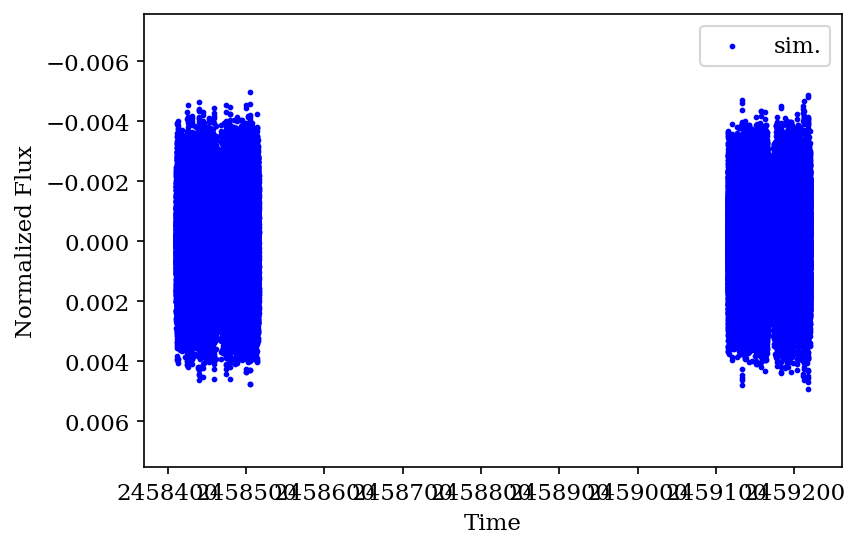

In [22]:
#Phases

f_TESS = f_TESS[:20]
a_TESS = a_TESS[:20]
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

model_times = lc_model_times(f_TESS, a_TESS, p_TESS*2*np.pi, times_pm_em, 20*np.sqrt(30)*1e-6)

#Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(times_pm_em, model_times[4], s=3, c='b', label = 'sim.')

ax.set_xlabel('Time')
ax.set_ylabel('Normalized Flux')
ax.legend()
ax.invert_yaxis()

#plt.savefig('posteriori.png')

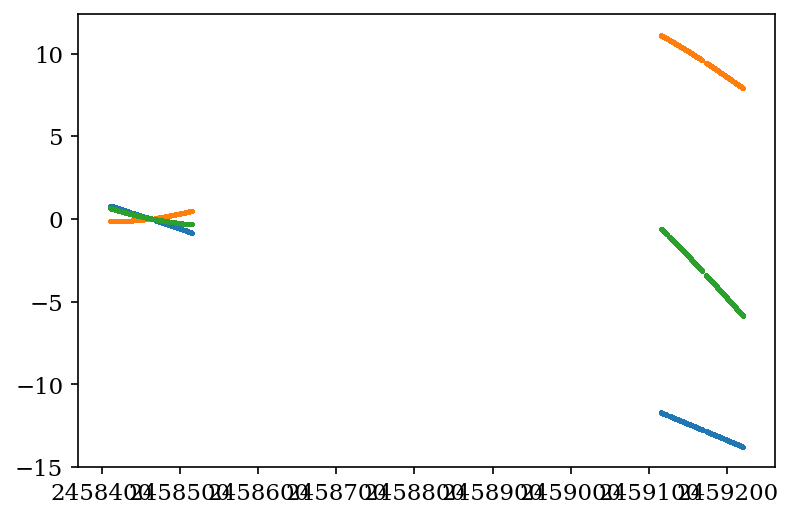

In [23]:
#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117

y_tau_b = tau(times_pm_em, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c = tau(times_pm_em, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

plt.scatter(times_pm_em, (y_tau_b-y_tau_b_offset)*86400, s=1)
plt.scatter(times_pm_em, (y_tau_c-y_tau_c_offset)*86400, s=1)
plt.scatter(times_pm_em, (y_tau_b + y_tau_c-y_tau_b_offset-y_tau_c_offset)*86400, s=1)

In [24]:
np.arange(0, len(times_pm_em)+len(times), len(times))

array([     0,  64609, 129218])

DEFINE AS FUNTION
CALCULATE FREQS OF BETA PIC
98
CALCULATE TIMES
CREATE MULTISINE MODEL
CALCULATE TIME DELAYS (MODEL)
CALCULATE TIME DELAYS (DATA)
0
64608
[array([4.74917084, 1.73071567, 1.92002172])]
1
129217
[array([4.74917084, 1.73071567, 1.92002172]), array([4.74239986, 0.30373121, 3.32012604])]
[[-0.13958516 -0.14635613]
 [-3.15804032  1.69816053]
 [-2.96873427  4.71455535]]
Calc TD
DOWNLOAD JDs
CALCULATE WEIGHTED VALUES
PLOT EVERYTHING


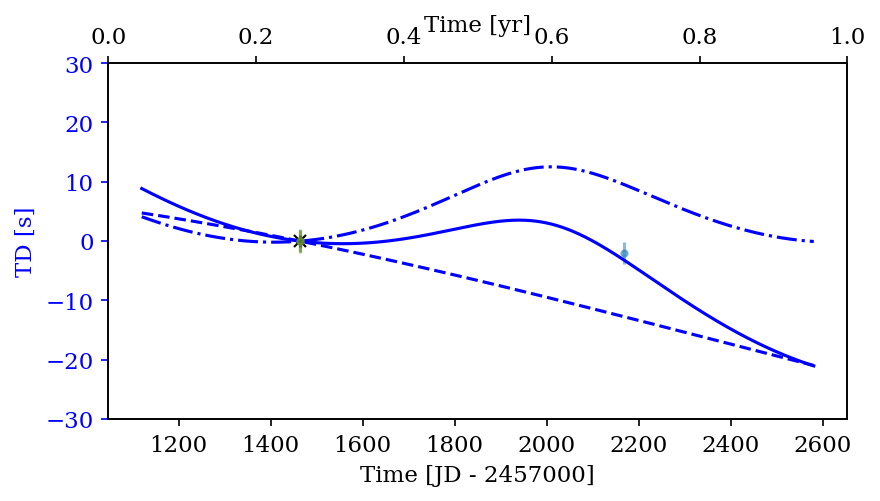

In [26]:
no_freqs_run = 3
no_freqs_run_weighted = 3

# noise_TESS_mag_hour_ppm = 19.91
# noise_hour_ppm = noise_TESS_mag_hour_ppm
#segment_size = 20

#pres = '0-0-0-0-0-0-0-19.91'

#everythingB = idiot2([0,1,2,7], times_all, [0,0,0,19.91], f_TESS, a_TESS, p_TESS)
#everythingA = idiot2([5,6,7], times_all, [0,0,0,19.91], f_TESS, a_TESS, p_TESS)
#everythingR = idiot2([3,4,7], times_all, [0,0,0,19.91], f_TESS, a_TESS, p_TESS)

# print('DOWNLOAD DATA')
# for name in ['beta Pictoris']:
#     sr = lk.search_lightcurvefile(name)
#     print(sr)

#     if len(sr) > 0:

#         #Download data
#         lcfs = sr.download_all()

#         # Use the normalized PDCSAP_FLUX
#         lc0 = lcfs[0].SAP_FLUX.normalize()
#         lc1 = lcfs[0].PDCSAP_FLUX.normalize()

#         # Loop through the rest of the LCFS, appending to the first light curve
#         for lcf in lcfs[1:]:
#             lc0 = lc0.append(lcf.SAP_FLUX.normalize())
#             lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

#         #Remove bad quality and nans
#         q0 = lc0.quality == 0
#         lc0 = lc0[q0].remove_nans()
#         q1 = lc1.quality == 0
#         lc1 = lc1[q1].remove_nans()
#         #Plot data
#         ax = lc0.scatter(label = 'SAP_FLUX')
#         lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
#         #Times & Mags
#         times = lc1.time + 2457000
#         mags = -2.5 * np.log10(lc1.flux)
#         mags = mags - np.median(mags)
        
#         x = times
#         y = mags

        
print('DEFINE AS FUNTION')
#Amplitude Spectrum Function
def AS(times, flux, oversample):
    timebase = max(times) - min(times)
    tmin = min(times)
    tmax = max(times)
    df = 1.0 / (tmax - tmin)
    dt = np.median(np.diff(times))
    ny = 0.5 / dt
    oversample = oversample

    freq = np.arange(df, 120, df / oversample)
    model = LombScargle(times, flux)
    power = model.power(freq, method = 'fast', normalization = 'psd')
    fct = np.sqrt(4 / len(times))
    amp = np.sqrt(np.abs(power)) * fct
    
    return((freq, amp))


print('CALCULATE FREQS OF BETA PIC')

#AS
freq, amp = AS(times, mags, 20)
freq=freq[5000:]
amp=amp[5000:]

# PEAKS
max_power = amp.max()
peaks, _ = find_peaks(amp, height=max_power*0.02, distance=200)

# FREQS SORTED BY AMPLITUDE
sort_idx = np.argsort(amp[peaks])[::-1]
f_TESS = freq[peaks][sort_idx]
a_TESS = amp[peaks][sort_idx]
print(len(f_TESS))





print('CALCULATE TIMES')



times_run = times_pm_em
magnitudes_run = model_times[4]
segment_borders = np.arange(0, len(times_pm_em)+len(times), len(times))#np.arange(0, 110000, 10000)#[0 , len(times), 2*len(times)]



print('CREATE MULTISINE MODEL')

#Phases
f_TESS = f_TESS[:no_freqs_run]
a_TESS = a_TESS[:no_freqs_run]
p_TESS = dft_phase(times, mags, f_TESS)/(2*np.pi)

#model_times = lc_model_times(f_TESS, a_TESS, p_TESS*2*np.pi, times_run, noise_run)


print('CALCULATE TIME DELAYS (MODEL)')
#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117



#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.9 * 1048
a2sini_c = 2.7 * np.sin(np.deg2rad(88.81))
e_c = 0.24
varpi_c = np.deg2rad(-95)
Porb_c = 1220
tp_c = 2454117

y_tau_b = tau(times_run, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b = vrad(times_KIC, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(times_run, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c = vrad(times_KIC, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)




print('CALCULATE TIME DELAYS (DATA)')


times_TD = times_run - y_tau_b - y_tau_c
magnitudes_TD = magnitudes_run
# print(times_TD)
# print(magnitudes_TD)

time_0 = times_TD[0]
time_slice, mag_slice, phase, phase_err = [], [], [], []
time_delays, time_delays_err, time_midpoints = [], [], []


t_edge = []

iteration = 0


# Iterate over lightcurve
for t, y, idx in zip(times_TD, magnitudes_TD, range(len(times_run))):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if idx == segment_borders[iteration+1]-1:
        print(iteration)
        print(idx)
        #print('{0}/{1}'.format(counter, size))
        # Append the time midpoint
        
        time_slice = np.array(time_slice)
        mag_slice = np.array(mag_slice)
        
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        
        phase_guess = dft_phase(time_slice, mag_slice, f_TESS)
        sol = fit_leastsq_my(time_slice, mag_slice, f_TESS, a_TESS, phase_guess/(2*np.pi))
        
        #print(phase_guess)
        phase.append(phase_guess)
        phase_err.append(sol[3]*2*np.pi)
        
        time_slice, mag_slice = [], []

        t_edge.append(t)
        iteration += 1         
        print(phase)
        
#print(time_midpoints) 
#phase = np.array(phase).T
#phase_err = np.array(phase_err).T

phase = np.unwrap(phase)
phase -= np.mean(phase)
phase = np.array(phase).T
phase_err = np.array(phase_err).T

print(phase)

print('Calc TD')
# Phase wrapping patch
for ph, ph_err, f in zip(phase, phase_err, f_TESS):
    td = ph / (2*np.pi*f)
    time_delays.append(td-np.mean(td))
    time_delays_err.append(ph_err / (2*np.pi*f))

    

print('DOWNLOAD JDs')
jds = []
for i in np.arange(2018, 2023, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    #print(t)
    #print(t.jd)
    jds.append(t.jd[0])    



print('CALCULATE WEIGHTED VALUES')

time_delays_tmp = time_delays[:no_freqs_run_weighted]
time_delays_err_tmp = time_delays_err[:no_freqs_run_weighted]

td_weighted = []
td_weighted_err = []
for i in range(len(time_midpoints)):
    #print(i)
    tds, tds_err = [], []
    for j in range(len(time_delays_tmp)):
        #print(j)
        tds.append(time_delays_tmp[j][i])
        tds_err.append(time_delays_err_tmp[j][i])
    tds = np.array(tds)
    tds_err = np.array(tds_err)
    td_weighted.append(sum(tds/tds_err**2)/sum(1/tds_err**2))
    td_weighted_err.append((1/sum(1/tds_err**2))**(1/2))
td_weighted = np.array(td_weighted)
td_weighted_err = np.array(td_weighted_err)





print('PLOT EVERYTHING')
times_sim = np.linspace(jds[0], jds[-1], 1000)

y_tau_b_sim_curve = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b_sim = vrad(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim_curve = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c_sim = vrad(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = 2457000

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset



#ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)
# lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim - td_weighted[-1]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
# lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - td_weighted[-1]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
# lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - td_weighted[-1]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")
ax1.set_xlabel('Time [JD - 2457000]')

ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-30, 30)
#ax1.set_xlim(t_2014, t_2020)

#ax2 = ax1.twinx()
# lns2 = ax2.plot(times_sim - time_offset, y_vrad_b + y_vrad_c, 'r', label = "RV curve")
# ax2.plot(times_sim - time_offset, y_vrad_b , 'r', label = "RV curve", ls = '--')
# ax2.plot(times_sim - time_offset, y_vrad_c, 'r', label = "RV curve", ls = '-.')
# ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
# ax2.tick_params('y', colors='r')

#lns = lns1+lns2
#labs = [l.get_label() for l in lns]


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

#ax2.set_xticks([t_2014,t_2016,t_2018,t_2020])

#ax1.set_xlim(1070,1090)
#ax1.set_ylim(-120,70)

xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
#ax2.set_xticklabels(['2014', '2016', '2018', '2020'], fontsize=10)


ax2.set_xlabel('Time [yr]', labelpad=-200)
ax2.xaxis.set_label_coords(0.5,1.09)


#ax1.set_xlabel('BJD - 2457000.0 [d]')
#ax1.set_ylabel('magnitudes [mmag]')

#ttl = ax1.title
#ttl.set_position([.5, 1.05])

#ax1.set_title('bRing+BLb')


#lns3 = ax1.axvspan(min(times_KIC) - time_offset, max(times_KIC) - time_offset, alpha=0.5,  label='TESS')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')


y_tau_b_sim = tau(np.array(time_midpoints), star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_sim = tau(np.array(time_midpoints), star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

lns11 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve + y_tau_c_sim_curve - y_tau_b_sim[0] - y_tau_c_sim[0]) *86400, 'b', label = r"TD $\beta$ Pic b&c")
lns12 = ax1.plot(times_sim - time_offset, (y_tau_b_sim_curve - y_tau_b_sim[0]) *86400, 'b', ls = '--', label = r"TD $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_tau_c_sim_curve - y_tau_c_sim[0]) *86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c")

#y_offset = (y_tau_b_sim[-1] + y_tau_c_sim[-1]) *86400 - td_weighted[-1]*86400
#ax1.scatter(np.array(time_midpoints) - time_offset, td_weighted*86400+y_offset, marker='x', c='k')   
lns2 = ax1.errorbar(np.array(time_midpoints) - time_offset, (td_weighted-td_weighted[0])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')

leg_errbar = []
for i in range(no_freqs_run):
    #ax1.scatter(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, s=5)
    lns3 = ax1.errorbar(np.array(time_midpoints) - time_offset, (time_delays[i]-time_delays[i][0])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)
    #ax1.set_ylim(-30, 30)
    leg_errbar.append(lns3)

# from mpl_toolkits.axes_grid.inset_locator import inset_axes
# inset_axes1 = inset_axes(ax1, 
#                     width="40%", # width = 30% of parent_bbox
#                     height=0.7, # height : 1 inch
#                     loc=2)
# plt.scatter(times_TD, magnitudes_TD, s=0.5, c='k')
# plt.xlim(min(times_TD)+1, min(times_TD)+3)
# #plt.title('One day zoom')
# #plt.xticks([min(times_TD)+1, min(times_TD)+3])
# #plt.yticks([min(magnitudes_TD), 0, max(magnitudes_TD)])
# plt.xticks([])
# plt.yticks([])

# inset_axes2 = inset_axes(ax1, 
#                     width="30%", # width = 30% of parent_bbox
#                     height=0.7, # height : 1 inch
#                     loc=8)
# plt.plot(AS(times_TD, magnitudes_TD, 2)[0], AS(times_TD, magnitudes_TD, 2)[1]*1e6, lw=0.1, c='k')
# plt.xlim(35, 60)
# plt.ylim(0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6)
# #plt.title('AS')
# #plt.xticks([35, 60])
# #plt.yticks([0, max(AS(times_TD, magnitudes_TD, 2)[1])*1e6])
# plt.xticks([])
# plt.yticks([])



# lns = [lns1[0], lns2[0], lns4, lns5, lns6, lns3]
# labs = [l.get_label() for l in lns]

#ax1.legend()
#ax1.legend(lns, labs, loc=4)

lns = [lns11[0], lns12[0], lns13[0], lns2]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]

#https://stackoverflow.com/questions/52038171/how-to-create-two-legend-objects-for-a-single-plot-instance/52040748#52040748
#ax1.legend(handles = lns[:3]+[tuple(leg_errbar[:3])]+lns[3:], labels=labs[:3]+['f1, f2, f3, ...']+labs[3:],loc=4,
#               handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)})


# textstr = '\n'.join((
#     'rms b=%.1f' % (rms2(y_tau_b_sim*86400-(td_weighted*86400+y_offset)), ),
#     'rms b+c=%.1f' % (rms2((y_tau_b_sim+y_tau_c_sim)*86400- (td_weighted*86400+y_offset)), )))
# ax1.text(0.02, 0.25, textstr, transform=ax.transAxes, fontsize=8,
#         verticalalignment='top')


fig.tight_layout()
plt.show()

#fig.savefig("TD_Kepler-Seg{0}-NoF{1}-NoFw{2}-Noisehr{3}-len{4}.png".format(segment_size, no_freqs_run, no_freqs_run_weighted, noise_hour_ppm, len(times_TD)), dpi=400)




t_td_BT = np.array(time_midpoints)
tau_td_BT = []
for j in range(len(f_TESS)):
    tau_td_BT.append(np.array([i for i in time_delays][j]-[i for i in time_delays][j][0]))
tau_td_BT = np.array(tau_td_BT)*86400
tau_err_td_BT = np.array(time_delays_err)*86400
tau_weighted_td_BT = td_weighted*86400-td_weighted[0]*86400
tau_err_weighted_td_BT = td_weighted_err*86400






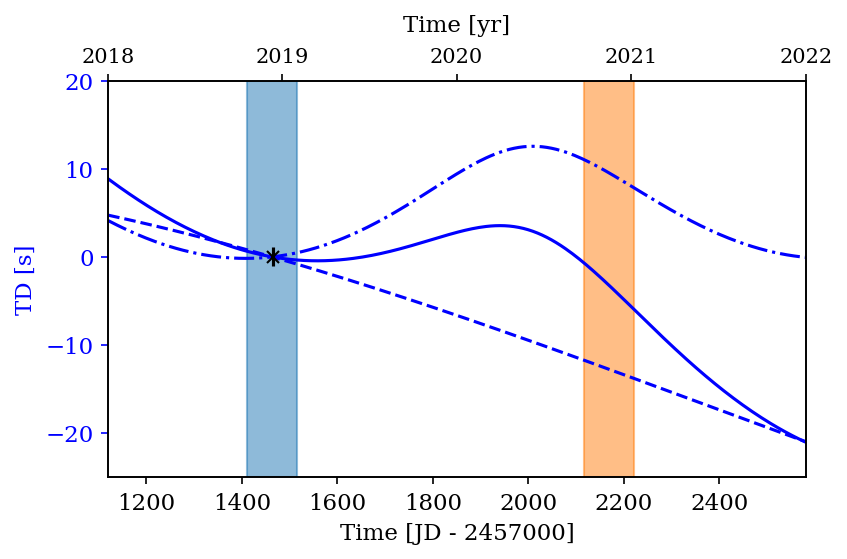

In [28]:
t_18_22 = np.linspace(jds[0], jds[-1], 300)


#_b
star_planet_ratio_b = 1.8 / 11 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.93 * 1048
a2sini_c = 2.6947 * np.sin(np.deg2rad(88.81))
e_c = 0.2425
varpi_c = np.deg2rad(-95.2)
Porb_c = 1220
tp_c = 2454116.5


TESS_mm_tmid = min(times) + (max(times) - min(times))/2

y_tau_b_offset = tau(TESS_mm_tmid, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c_offset = tau(TESS_mm_tmid, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

y_tau_b = tau(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
#y_vrad_b = vrad2(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_tau_c = tau(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
#y_vrad_c = vrad2(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

time_offset = 2457000

fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))


ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

lns11 = ax1.plot(t_18_22 - time_offset, (y_tau_b + y_tau_c-y_tau_b_offset-y_tau_c_offset) * 86400, 'b', label = r"TD $\beta$ Pic b&c",zorder=-32)
lns12 = ax1.plot(t_18_22 - time_offset, (y_tau_b-y_tau_b_offset) * 86400, 'b', ls = '--', label = r"TD $\beta$ Pic b",zorder=-32)
lns13 = ax1.plot(t_18_22 - time_offset, (y_tau_c-y_tau_c_offset) * 86400, 'b', ls = '-.', label = r"TD $\beta$ Pic c",zorder=-32)




lns31 = ax1.axvspan(min(times) - time_offset, max(times) - time_offset, alpha=0.5,  label='TESS (mm)', color='C0',zorder=-200)
lns32 = ax1.axvspan(min(times)+705 - time_offset, max(times)+705 - time_offset, alpha=0.5,  label='TESS (em)', color='C1',zorder=-200)

ax1.set_xlabel('Time [JD - 2457000]')
ax1.set_ylabel('TD [s]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(-25,20)


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset
t_2022 = jds[4] - time_offset


ax2.set_xticks([t_2018,t_2019,t_2020,t_2021,t_2022])


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2018', '2019', '2020', '2021', '2022'], fontsize=10)
ax2.set_xlabel('Time [yr]')
ax2.xaxis.set_label_coords(0.5,1.125)

#ax1.axhline((tau(TESS_mm_tmid+705, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400)
#ax1.axhline((tau(TESS_mm_tmid+705, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)-y_tau_c_offset+tau(TESS_mm_tmid+705, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)-y_tau_b_offset)*86400)




leg_errbar = []
for i in range(no_freqs_run):
    #ax1.scatter(np.array(time_midpoints) - time_offset, time_delays[i]*86400+y_offset, s=5)
    #lns3 = ax1.errorbar(np.array(time_midpoints) - time_offset, (time_delays[i]-time_delays[i][0])*86400, yerr = time_delays_err[i]*86400, fmt='.', alpha = ((a_TESS[i]/a_TESS[0])**2)/2)
    #ax1.set_ylim(-30, 30)
    leg_errbar.append(lns3)
    
lns2 = ax1.errorbar(np.array(time_midpoints) - time_offset, (td_weighted-td_weighted[0])*86400, yerr = td_weighted_err*86400, fmt='.', marker='x', c='k', label = 'weighted')


SearchResult containing 13 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
   38846515 tess2018206045859-s0001-0000000038846515-0120-s_lc.fits Light curves      0.0
   38846515 tess2018234235059-s0002-0000000038846515-0121-s_lc.fits Light curves      0.0
   38846515 tess2018263035959-s0003-0000000038846515-0123-s_lc.fits Light curves      0.0
   38846515 tess2018292075959-s0004-0000000038846515-0124-s_lc.fits Light curves      0.0
   38846515 tess2018319095959-s0005-0000000038846515-0125-s_lc.fits Light curves      0.0
   38846515 tess2018349182459-s0006-0000000038846515-0126-s_lc.fits Light curves      0.0
   38846515 tess2019006130736-s0007-0000000038846515-0131-s_lc.fits Light curves      0.0
   38846515 tess2019032160000-s0008-0000000038846515-0136-s_lc.fits Light curves      0.0
   38846515 tess2019058134432-s0009-0000000038846515-0139

SearchResult containing 13 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
   25155310 tess2018206045859-s0001-0000000025155310-0120-s_lc.fits Light curves      0.0
   25155310 tess2018234235059-s0002-0000000025155310-0121-s_lc.fits Light curves      0.0
   25155310 tess2018263035959-s0003-0000000025155310-0123-s_lc.fits Light curves      0.0
   25155310 tess2018292075959-s0004-0000000025155310-0124-s_lc.fits Light curves      0.0
   25155310 tess2018319095959-s0005-0000000025155310-0125-s_lc.fits Light curves      0.0
   25155310 tess2018349182459-s0006-0000000025155310-0126-s_lc.fits Light curves      0.0
   25155310 tess2019006130736-s0007-0000000025155310-0131-s_lc.fits Light curves      0.0
   25155310 tess2019032160000-s0008-0000000025155310-0136-s_lc.fits Light curves      0.0
   25155310 tess2019058134432-s0009-0000000025155310-0139

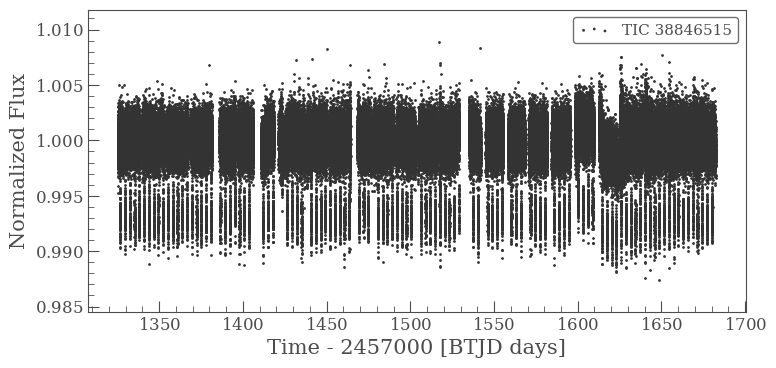

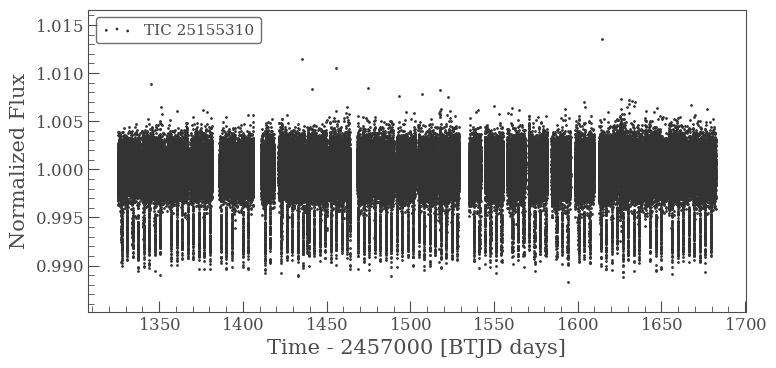

In [226]:
sr_WASP100 = lk.search_lightcurvefile('WASP100')
print(sr_WASP100)
lc_WASP100 = sr_WASP100.download_all()
lc_WASP100tmp = lc_WASP100[0].PDCSAP_FLUX.normalize()
for bll in lc_WASP100[1:]:
    lc_WASP100tmp = lc_WASP100tmp.append(bll.PDCSAP_FLUX.normalize())
lc_WASP100tmp.scatter()

sr_WASP126 = lk.search_lightcurvefile('WASP126')
print(sr_WASP126)
lc_WASP126 = sr_WASP126.download_all()
lc_WASP126tmp = lc_WASP126[0].PDCSAP_FLUX.normalize()
for bll in lc_WASP126[1:]:
    lc_WASP126tmp = lc_WASP126tmp.append(bll.PDCSAP_FLUX.normalize())
lc_WASP126tmp.scatter()

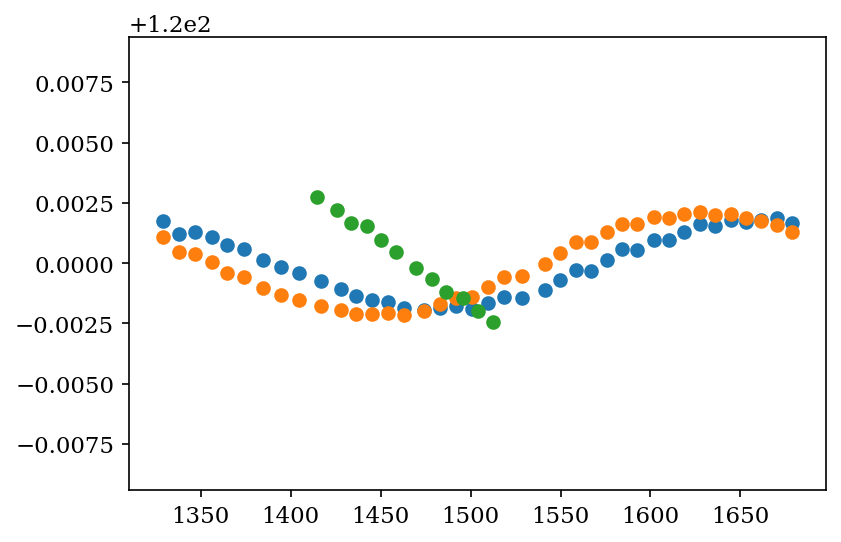

In [236]:
nn = 3*13
tmp_cad = []
tmp_mid = []
for i in range(nn):
    len_times = len(lc_WASP100tmp.time)//nn
    times_tmp = lc_WASP100tmp.time[len_times*i:len_times*(i+1)]
    #print(times_tmp)
    #print(np.median(np.diff(times_tmp))*86400)
    tmp_cad.append(np.median(np.diff(times_tmp))*86400)
    tmp_mid.append(np.mean(times_tmp))

nn = 3*13
tmp_cad2 = []
tmp_mid2 = []
for i in range(nn):
    len_times = len(lc_WASP126tmp.time)//nn
    times_tmp = lc_WASP126tmp.time[len_times*i:len_times*(i+1)]
    #print(times_tmp)
    #print(np.median(np.diff(times_tmp))*86400)
    tmp_cad2.append(np.median(np.diff(times_tmp))*86400)
    tmp_mid2.append(np.mean(times_tmp))

    
nn = 3*4
tmp_cad3 = []
tmp_mid3 = []
for i in range(nn):
    len_times = len(times)//nn
    times_tmp = times[len_times*i:len_times*(i+1)]
    #print(times_tmp)
    #print(np.median(np.diff(times_tmp))*86400)
    tmp_cad3.append(np.median(np.diff(times_tmp))*86400)
    tmp_mid3.append(np.mean(times_tmp))
    

plt.scatter(tmp_mid, tmp_cad)
plt.scatter(tmp_mid2, tmp_cad2)
plt.scatter(np.array(tmp_mid3)-2457000, tmp_cad3)